# QAOA simulation with noise mitigation

This notebook shows a simulation of QAOA with an error mitigation based on a neural network.

## Graph loading

First, we load a 10 node graph. We also plot it with the nodes color coded according to the maximum cut that we find with CEPLEX.

In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx

from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.applications import Maxcut

In [2]:
data = json.load(open("../data/graphs/10nodes/graph_2layers_0seed.json", "r"))
graph = nx.from_edgelist(data["Original graph"])

In [3]:
max_cut = Maxcut(nx.adjacency_matrix(graph))
problem = max_cut.to_quadratic_program()

optimizer = CplexOptimizer()
cplex_result = optimizer.solve(problem)

colors = [[102/255, 210/255, 172/255] if x == 0 else [60/255, 82/255, 150/255] for x in cplex_result.x]
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
pos = nx.spring_layout(graph)
nodes = nx.draw_networkx_nodes(graph, pos, node_color=colors, ax=ax)
nx.draw_networkx_edges(graph, pos, width=2, ax=ax)
nodes.set_edgecolor("k")
plt.box(False)

## Backend creation

We create a noisy backend to work with. The noise of this backend is stronger than the actual noise of an IBM Quantum backend so that a depth-two QAOA circuit with ten nodes is close to the limit of what the error mitigation can handle. We build a noise model with short-lived qubits. Their $T_1$ and $T_2$ times are sampled from a Gaussian distribution with $10~\mu s$ mean and $10~ns$ standard deviation. Based on these durations, a thermal relaxation noise channel is applied to the CNOT gates lasting $\tau_{\rm cnot} = 300~ns$. This is a strong noise model for the 102 CNOT gates in the
QAOA circuit as understood, e.g., by $\exp\{-\tau_{\rm cnot}/T_1\}$ which gives 97% as proxy for the gate fidelity. The other circuit instructions are noiseless.

In [4]:
import numpy as np

from qiskit_aer import QasmSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error

In [5]:
T1s = np.random.normal(10000, 10, len(graph)) # Sampled from normal distribution in ns
T2s = np.random.normal(10000, 10, len(graph))

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(len(graph))])

time_cx = 300  # CX Instruction times (in nanoseconds)

# QuantumError objects
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(thermal_relaxation_error(t1b, t2b, time_cx))
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(len(graph)):
    for k in range(len(graph)):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

We create a noisy and a noiseless simulator. Furthermore, we fix the seed to make the results reproducible.

In [6]:
backend = QasmSimulator(noise_model=noise_thermal)
backend.set_options(seed_simulator= 123)
noiseless = QasmSimulator()
noiseless.set_options(seed_simulator= 123)
np.random.seed(seed=123)

## QAOA Circuit

Now, we construct the depth-two QAOA circuit using a SAT mapped graph.

In [7]:
from large_scale_qaoa import qaoa

In [8]:
em_qaoa = qaoa.ErrorMitigationQAOA(
    shots=4096,
    path=list(range(len(graph))),
    local_correlators=data["paulis"],
    backend=backend,
)

The code below shows that the circuit has a regular structure. Furthermore, each QAOA layer requires only two layers of SWAP gates as promised by the SAT initial mapping.

In [9]:
em_qaoa.create_qaoa_circ_pauli_evolution(
    [1, 1, 1, 1], 
    random_cut=[1, 1, 0, 0, 0, 0], 
    superposition=False, 
    transpile_circ=True
).draw("mpl", fold=False)

## Neural network training

First, we generate data to trian the neural network. This data is generated by sending random graph cuts through the QAOA circuit in which the $R_z$ gates of the QAOA cost operator are replaced with barriers. We measure the noisy correlators $\mathcal{X}$ at the output of the circuit. Since the circuits without $R_z$ gates can be efficiently simulated classically we can compute noiseless correlators $\mathcal{Y}$. This then allows us to train a neural network to create a map from noisy data $\mathcal{X}$ to noiseless data $\mathcal{Y}$.

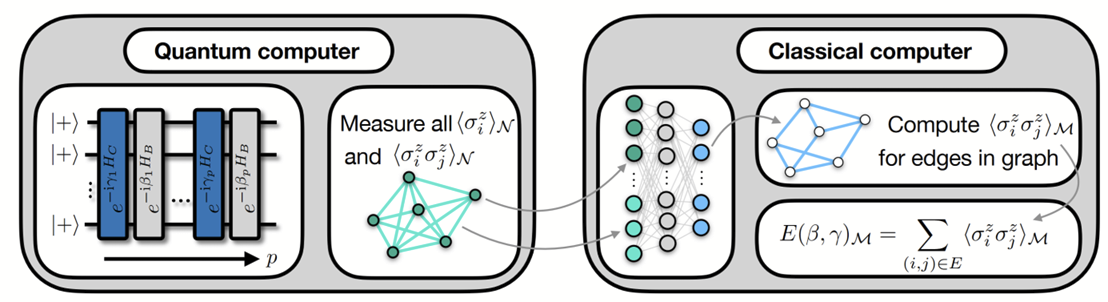

In [10]:
from sklearn.neural_network import MLPRegressor

from large_scale_qaoa import ml_denoising

In [11]:
p = 2
X, Y = [], []
training_data_size = 300

# Generate training data
while len(X) < training_data_size:
    print("new batch")
    X_is, Y_is, job_id = ml_denoising.get_data(p, em_qaoa, 50)
    for idx in range(len(X_is)):
        X.append(X_is[idx])
        Y.append(Y_is[idx])
        
# Generate validation data
Xv, Yv = [], []
validation_data_size = 20
while len(Xv) < validation_data_size:
    X_is, Y_is, job_id = ml_denoising.get_data(p, em_qaoa, 20)
    for idx in range(len(X_is)):
        Xv.append(X_is[idx])
        Yv.append(Y_is[idx])

Second, we create a feed-forward neural network and train it with the data we just generated. The details on the neural network can be found in the paper *"Large-scale quantum approximate optimization on non-planar graphs with machine learning noise mitigation"*.

In [12]:
n_hidden = int((em_qaoa.N * 3) / 4 + em_qaoa.N * (em_qaoa.N - 1) / 4 + em_qaoa.N / 2)

regr = MLPRegressor(
    random_state=1,
    learning_rate="adaptive",
    batch_size=5,
    hidden_layer_sizes=n_hidden,
    activation="logistic",
    max_iter=4000,
    solver="sgd",
    early_stopping=True,
).fit(X, Y)
em_qaoa.regr = regr

Ypred = []
for x in Xv:
    Ypred.append(regr.predict([x]))

In [13]:
plt.rcParams["font.size"] = 13

fig, axs = plt.subplots(1, 2, figsize=(8, 3.0))
axs[0].plot([_*100 for _ in regr.loss_curve_], lw=2, color=[60/255, 82/255, 150/255])
par1 = axs[0].twinx()
par1.plot([_*100 for _ in regr.validation_scores_], color=[102/255, 210/255, 172/255])
par1.set_ylabel("$R^2$ score (%)", color=np.array([102/255, 210/255, 172/255])*0.8, labelpad=-1)
axs[1].plot([-1, 1], [-1, 1], "--k", zorder=-10)

indices = list(em_qaoa.G.edges())
markers = ["v", "^", "o", "s"]
mako_colors = [[173, 226, 191], [53, 160, 170], [60, 82, 150], [53, 38, 75]]
for subidx, idx in enumerate(range(0, 8, 2)):
    zz = f"Z_{indices[idx][0]}Z_{indices[idx][1]}"
    label = "$\langle "+zz+" \\rangle$"
    axs[1].scatter(
        [y[idx] for y in Yv], [y[0][idx] for y in Ypred], edgecolor="k", 
        linewidth=0.4, s=20, label=label, marker=markers[subidx], color=np.array(mako_colors[subidx])/255
    )
    
axs[0].set_ylabel("Loss function (%)", color=np.array([60/255, 82/255, 150/255])*0.8, labelpad=-1)
axs[0].set_xlabel("Iteration")
    
axs[1].set_xlabel("Ideal Y")
axs[1].set_ylabel("Predicted Y", labelpad=-12)
axs[1].legend(loc=4, fontsize=12, labelspacing=0.3, handlelength=0.5)

axs[0].text(0.1, 0.9, "(a)", fontsize=14, transform=axs[0].transAxes)
axs[1].text(0.1, 0.9, "(b)", fontsize=14, transform=axs[1].transAxes)

axs[1].set_yticks([-1, 0, 1])

plt.subplots_adjust(wspace=0.37)

## Error mitigated QAOA

Now that we have trained a neural network for the error mitigation, we can see how well it does. We will do this twice: once on the error mitigated cost function and once on the non-error mitigated cost function. In both cases, we will initialize the QAOA parameters with the Trotterized Quantum Annealing approach as described in Sack & Serbyn, *"Quantum annealing initialization of the quantum approximate optimization algorithm"*, Quantum **5**, 491 (2021).

In [14]:
from scipy.optimize import minimize

In [15]:
dt = 0.75
p = 2
grid = np.arange(1, p + 1) - 0.5
init_params = np.concatenate((1 - grid * dt / p, grid * dt / p))

#### Optimization on the error mitigated cost function

In [16]:
def save_denoised(x):
    cost = cost_denoised(x)
    cost_noisy = em_qaoa.cost_noisy(x)
    history_denoised.append([x, cost, cost_noisy])
    
def cost_denoised(theta):
    """Denoised objective value"""
    local_exp_Z, local_exp_ZZ = em_qaoa.evaluate_local_exp_on_device(theta, all_to_all=True)

    return sum(em_qaoa.regr.predict([local_exp_Z + local_exp_ZZ])[0])

history_denoised = []
result = minimize(
    cost_denoised,
    x0=init_params,
    method="COBYLA",
    callback=save_denoised,
    options={"maxiter": 100, "rhobeg":0.1}
)

denoised_counts = [_ for _ in em_qaoa.counts]
em_qaoa.counts = []

#### Optimization on the non-error mitigated cost function

In [17]:
def save_noisy(x):
    cost = cost_denoised(x)
    cost_noisy = em_qaoa.cost_noisy(x)
    history_noisy.append([x, cost, cost_noisy])
    
def cost_noisy(theta):
    """Denoised objective value"""
    return em_qaoa.cost_noisy(theta)

history_noisy = []
result = minimize(
    cost_noisy,
    x0=init_params,
    method="COBYLA",
    callback=save_noisy,
    options={"maxiter": 100, "rhobeg":0.1}
)

noisy_counts = [_ for _ in em_qaoa.counts]
em_qaoa.counts = []

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

axs[0].plot([_[1] for _ in history_denoised], label="Error mit. cost", color=[60/255, 82/255, 150/255])
axs[0].plot([_[2] for _ in history_denoised], ":", label="Non-error mit. cost", color=[60/255, 82/255, 150/255])
axs[0].plot([_[2] for _ in history_noisy], "--" ,label="Non-error mit. cost", color="firebrick")

labels = [r"$\gamma_1$", r"$\gamma_2$", r"$\beta_1$", r"$\beta_2$"]
for param_idx in range(2*p):
    axs[1].plot([val[0][param_idx] for val in history_denoised], color=f"C{param_idx}", label=labels[param_idx])
    axs[1].plot([val[0][param_idx] for val in history_noisy], "--", color=f"C{param_idx}")
    
for ax in axs:
    ax.set_xlabel("Iteration number")
    
axs[0].set_ylabel("Cost function value")
axs[1].set_ylabel("QAOA parameter values", labelpad=1)
axs[0].legend(frameon=False, fontsize=10, bbox_to_anchor=(0.5, 0.55))
axs[1].legend(frameon=False, fontsize=10, ncol=2, bbox_to_anchor=(0.5, 0.45))
axs[0].text(0.12, 0.9, "(a)", transform = axs[0].transAxes)
axs[1].text(0.03, 0.9, "(b)", transform = axs[1].transAxes)

plt.subplots_adjust(wspace=0.21, hspace=0.02)

Now, we want to estimate how well the optimized QAOA paraeters perform. Crucially, the noise mitigation was applied to an expectation value but the goal of QAOA is to draw *good samples*. We therefore compare both sets of QAOA parameters (i.e., with and without error mitigation) to a noiseless simulation. This is possible because the graph is small enough that we can still simulate it on a classical computer. The figures below show what we stand to gain if we were able to error mitigate samples as well as expectation values. The next cell is the noiseless simulation of the QAOA circuit with the initial TQA point and final optimized point.

In [19]:
from collections import defaultdict

def make_cost_histo(counts, qaoa):
    shots = sum(counts.values())
    cost_dict = defaultdict(int)
    for bitstr, count in counts.items():
        _, cost = qaoa.get_local_expectation_values_from_counts({bitstr: 1})
        cost_dict[sum(cost)] += count / shots * 100
        
    return cost_dict

In [20]:
circs = [
    em_qaoa.create_qaoa_circ_pauli_evolution(history_denoised[0][0], transpile_circ=True),
    em_qaoa.create_qaoa_circ_pauli_evolution(history_denoised[-1][0], transpile_circ=True),
    em_qaoa.create_qaoa_circ_pauli_evolution(history_noisy[0][0], transpile_circ=True),
    em_qaoa.create_qaoa_circ_pauli_evolution(history_noisy[-1][0], transpile_circ=True),
]
res = noiseless.run(circs).result()

nonoise_cost_i = make_cost_histo(res.get_counts(0), em_qaoa)
nonoise_cost_f = make_cost_histo(res.get_counts(1), em_qaoa)
nonoise_noisy_cost_i = make_cost_histo(res.get_counts(2), em_qaoa)
nonoise_noisy_cost_f = make_cost_histo(res.get_counts(3), em_qaoa)

The next cells create plots.

In [21]:
cost_i = make_cost_histo(denoised_counts[0], em_qaoa)   # initial point
cost_f = make_cost_histo(denoised_counts[-1], em_qaoa)  # final point
ncost_i = make_cost_histo(noisy_counts[0], em_qaoa)     # initial point
ncost_f = make_cost_histo(noisy_counts[-1], em_qaoa)    # final point

keys_i = sorted(list(cost_i.keys()))
keys_f = sorted(list(cost_f.keys()))
nkeys_i = sorted(list(ncost_i.keys()))
nkeys_f = sorted(list(ncost_f.keys()))

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))

axs = axs.flatten()

w = 0.8
axs[0].bar(
    [k - w/2 for k in keys_i], [cost_i[k] for k in keys_i], label="Initial $\\theta$",
    width=w, color=[60/255, 82/255, 150/255],edgecolor="royalblue"
)
axs[0].bar(
    [k + w/2 for k in keys_f], [cost_f[k] for k in keys_f], label="Last $\\theta$", 
    width=w, color=[102/255, 210/255, 172/255], edgecolor="darkgreen"
)
axs[0].legend(ncol=2, fontsize=11, frameon=False)
axs[0].text(
    0.95, 0.45, "Error mitigated\noptimization\n\nNoisy\nsampling", 
    transform = axs[0].transAxes, horizontalalignment="right",
)

axs[2].bar(
    [k - w/2 for k in nkeys_i], [ncost_i[k] for k in nkeys_i], label="Initial $\\theta$", 
    width=w, color=[112/255, 31/255, 87/255], edgecolor="k"
)
axs[2].bar(
    [k + w/2 for k in nkeys_f], [ncost_f[k] for k in nkeys_f], label="Last $\\theta$", 
    width=w, color=[246/255, 180/255, 143/255], edgecolor="firebrick"
)
axs[2].legend(ncol=2, fontsize=11, frameon=False)
axs[2].text(
    0.95, 0.45, "Non-error mitigated\noptimization\n\nNoisy\nsampling", 
    transform = axs[2].transAxes, horizontalalignment="right",
)

axs[1].bar(
    [k - w/2 for k in nkeys_i], [nonoise_cost_i[k] for k in nkeys_i], label="Initial $\\theta$", 
    width=w, color=[60/255, 82/255, 150/255],edgecolor="royalblue"
)
axs[1].bar(
    [k + w/2 for k in nkeys_f], [nonoise_cost_f[k] for k in nkeys_f], label="Last $\\theta$", 
    width=w, color=[102/255, 210/255, 172/255], edgecolor="darkgreen"
)

axs[1].text(
    0.95, 0.5, "Error mitigated\noptimization\n\nNoiseless\nsampling", 
    transform = axs[1].transAxes, horizontalalignment="right",
)

axs[3].bar(
    [k - w/2 for k in nkeys_i], [nonoise_noisy_cost_i[k] for k in nkeys_i], label="Initial $\\theta$", 
    width=w, color=[112/255, 31/255, 87/255], edgecolor="k"
)
axs[3].bar(
    [k + w/2 for k in nkeys_f], [nonoise_noisy_cost_f[k] for k in nkeys_f], label="Last $\\theta$", 
    width=w, color=[246/255, 180/255, 143/255], edgecolor="firebrick",
)

axs[3].text(
    0.95, 0.5, "Non-error mitigated\noptimization\n\nNoiseless\nsampling", 
    transform = axs[3].transAxes, horizontalalignment="right",
)

for ax in axs:
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])

for ax in [axs[1], axs[3]]:
    ax.set_yticklabels([""]*7)

for ax in [axs[2], axs[3]]:
    ax.set_xlabel("Cost function")
    
for ax in [axs[0], axs[2]]:
    ax.set_ylabel("Frequency (%)")

for idx, ax in enumerate(axs):
    ax.text(0.05, 0.9, {0: "(a)", 1: "(b)", 2: "(c)", 3: "(d)"}[idx], transform = ax.transAxes)
    ax.set_ylim([0, 30])

axs[2].set_yticks([0, 5, 10, 15, 20, 25])
axs[2].set_yticklabels(["0", "5", "10", "15", "20", "25"])
    
plt.subplots_adjust(wspace=0.02, hspace=0.02)

## Concluding remarks

The plots above show that the parameters optimized with error mitigation, see panels (a) and (b), produce better samples in a noiseless simulation.
By contrast the parameters optimized without the error mitigation, shown in panels (c) and (d), do not perform as well.
This suggests that the neural network has helped the optimizer to find better QAOA parameter values.
We caution that these results depend on the simulator seed.
We find that the error mitigated cost function is lower than the non-error mitigated cost function of the same simulation in almost all cases that we studied.
Furthermore, in a majority of simulations the error-mitigation helped find better QAOA parameters than a noisy simulation without error mitigation.
We did observe several simulations where the optimization without error mitigation produced better QAOA parameters than with error mitigation.
This may be due to the fact that the noise model is extremely strong compared to the  number of gates in the circuit.